In [34]:
import pandas as pd
import numpy as np
import re
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
!python -m spacy download en_core_web_sm

In [36]:
random_seed = 42
np.random.seed(random_seed)

# Получение данных
[
Spam or Not Spam Dataset](https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset/)

In [37]:
data = pd.read_csv('spam_or_not_spam.csv')
data = data.astype({'email':'string'})
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [38]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   string
 1   label   2999 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 70.3 KB


In [39]:
data['label'].value_counts()

label
0    2500
1     499
Name: count, dtype: int64

# Очистка

Стоп-слова для английского языка в spaCy

In [40]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"one 's yourself such nevertheless be what everything out yours yet does again 're of some were nine between made two regarding must none sometime sixty give seem ’re anything whatever his has someone no there cannot being hereby mostly the whom latter top when around behind five whereafter make fifteen after 'd him himself ourselves these herself well neither several ‘s very hers off us who is she than thus wherever serious an both anyhow ‘m first though forty others could fifty we more except me ours nothing seems thru few hereafter whoever quite various somewhere enough via within until front just not four ever nor whither all through also thereby those wherein else everywhere down by together them move becomes along moreover alone due any yourselves using still nobody 'm will eleven name should n’t call ‘ve thereafter n't show beside above their am third this with last part afterwards whole seeming something twelve beforehand besides if most whence least myself ’m before or i into 

Атрибуты [Token](https://spacy.io/api/token#attributes)

In [41]:
%%time

data['cleaned_text'] = data['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.head()

CPU times: total: 1min 54s
Wall time: 1min 54s


,email,label,cleaned_text
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,date d number aug number number number number ...
1,martin a posted tassos papadopoulos the greek ...,0,martin post tassos papadopoulo greek sculptor ...
2,man threatens explosion in moscow thursday aug...,0,man threaten explosion moscow thursday august ...
3,klez the virus that won t die already the most...,0,klez virus win t die prolific virus klez conti...
4,in adding cream to spaghetti carbonara which ...,0,add cream spaghetti carbonara effect pasta mak...


# Векторизация и классификация

## CountVectorizer

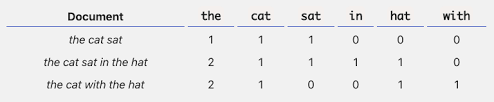

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

### Train/test split & fit

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=random_seed)

In [43]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train) 
X_test_vectorized = vectorizer.transform(X_test)

### Бейзлайн - константное предсказание

In [44]:
dummy_clf = DummyClassifier(random_state=random_seed, strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       627
           1       0.00      0.00      0.00       123

    accuracy                           0.84       750
   macro avg       0.42      0.50      0.46       750
weighted avg       0.70      0.84      0.76       750



### Логистическая регрессия

In [45]:
logreg = LogisticRegression(random_state=random_seed).fit(X_train_vectorized, y_train)
preds_count_vec = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       627
           1       0.97      0.93      0.95       123

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



### Переопределение токенизатора, препроцессинга

In [46]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [47]:
custom_vectorizer = CountVectorizer(
    max_df=0.7,
    min_df=0.003,
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
    token_pattern=None
)
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

In [48]:
logreg = LogisticRegression(random_state=random_seed).fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.97      0.93      0.95       123

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



Стало работать хуже с новым токенизатором.

## Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



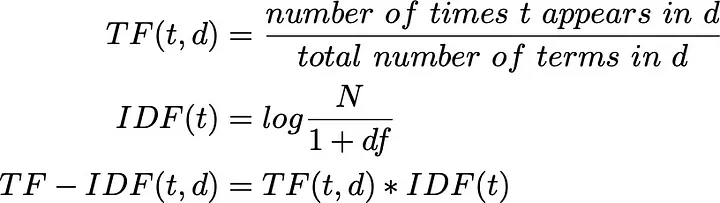

Отличия в реализации Sklearn

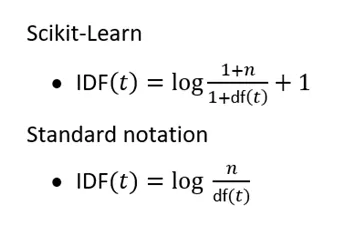

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity:
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

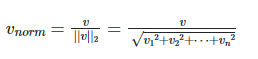

In [49]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=random_seed))
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       627
           1       1.00      0.75      0.86       123

    accuracy                           0.96       750
   macro avg       0.98      0.87      0.92       750
weighted avg       0.96      0.96      0.96       750



Сравним с CountVectorizer:

In [50]:
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       627
           1       0.97      0.93      0.95       123

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



Для разных задач нужно оптимизировать разные метрики, так что оба решения имеют место быть, к тому же, их еще можно запускать на разных параметрах.

# Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

## Логистическая регрессия

In [51]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=random_seed))
    ]
)

In [52]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [53]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

CPU times: total: 1min 36s
Wall time: 3min


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf',
                                               LogisticRegression(random_state=42))]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy')

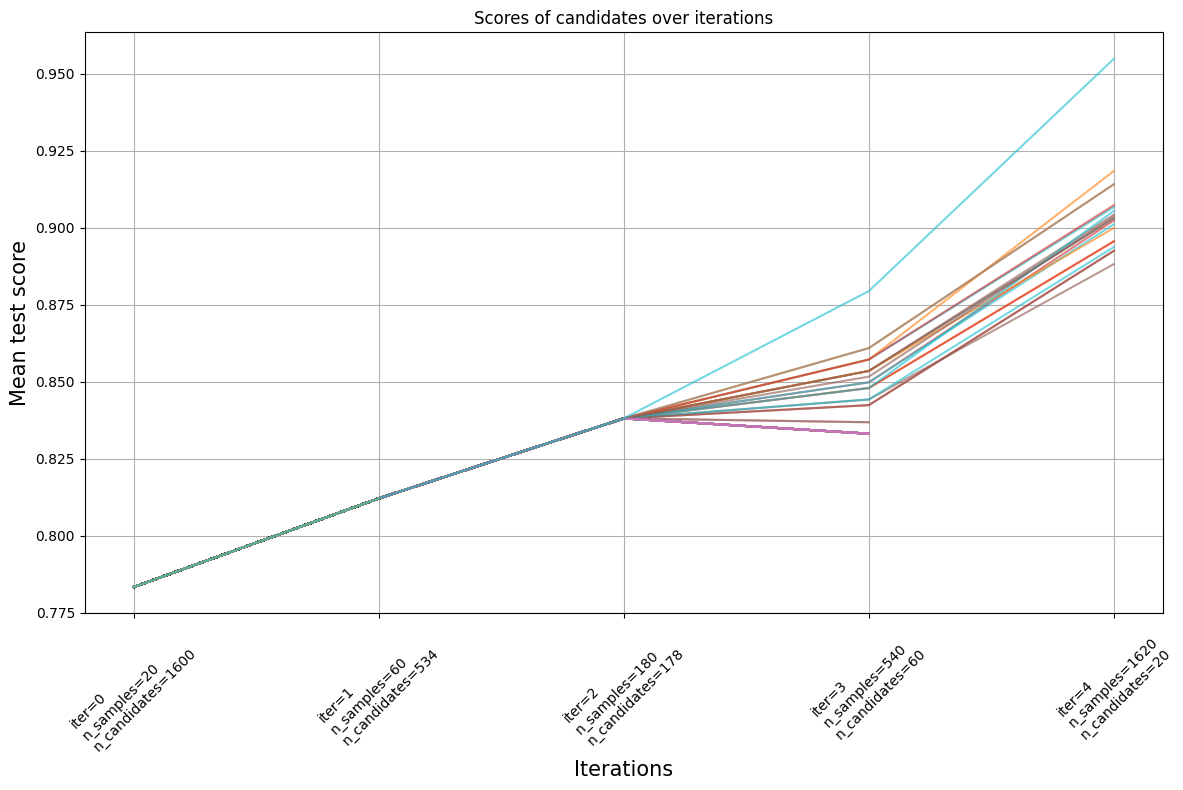

best_score: 0.9549096051676031


In [54]:
def plot(grid_search):
    plt.rcParams["figure.figsize"] = (12, 8)
    results = pd.DataFrame(grid_search.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter",
        columns="params_str",
        values="mean_test_score",
    )
    ax = mean_scores.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
        for i in range(grid_search.n_iterations_)
    ]

    ax.set_xticks(range(grid_search.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("Mean test score", fontsize=15)
    ax.set_xlabel("Iterations", fontsize=15)
    plt.tight_layout()
    plt.grid()
    plt.show()

plot(grid_search)
print("best_score:", grid_search.best_score_)

In [55]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       627
           1       1.00      0.84      0.91       123

    accuracy                           0.97       750
   macro avg       0.98      0.92      0.95       750
weighted avg       0.97      0.97      0.97       750



## Дерево решений

In [56]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier(random_state=random_seed))
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2")
}


In [57]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

CPU times: total: 12.2 s
Wall time: 46.1 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf',
                                               DecisionTreeClassifier(random_state=42))]),
                    n_jobs=-1,
                    param_grid={'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy')

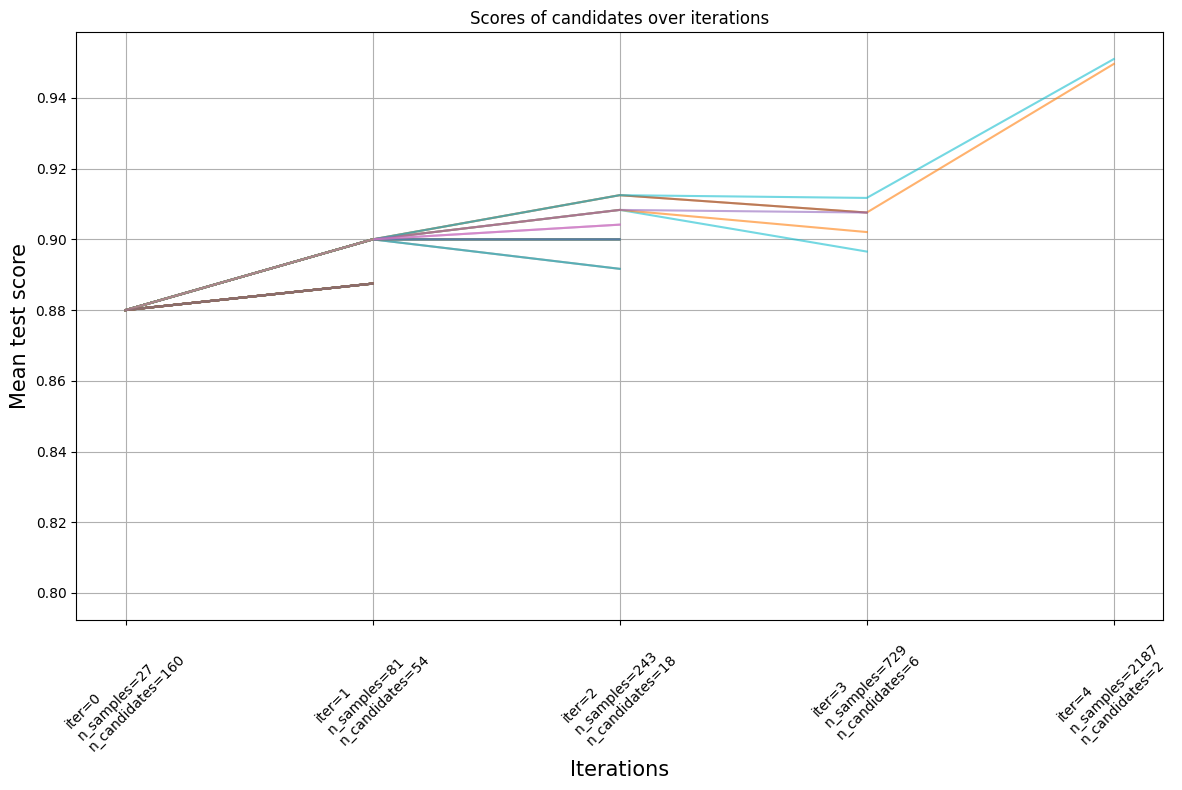

best_score: 0.9510108538198307


In [58]:
plot(grid_search)
print("best_score:", grid_search.best_score_)

In [59]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       627
           1       0.77      0.93      0.84       123

    accuracy                           0.94       750
   macro avg       0.88      0.94      0.90       750
weighted avg       0.95      0.94      0.94       750



## Наивный Байесовский классификатор

С CountVectorizer

In [61]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('clf', MultinomialNB())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
}


In [62]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

CPU times: total: 6.44 s
Wall time: 14 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=-1,
                    param_grid={'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2))},
                    random_state=42, scoring='accuracy')

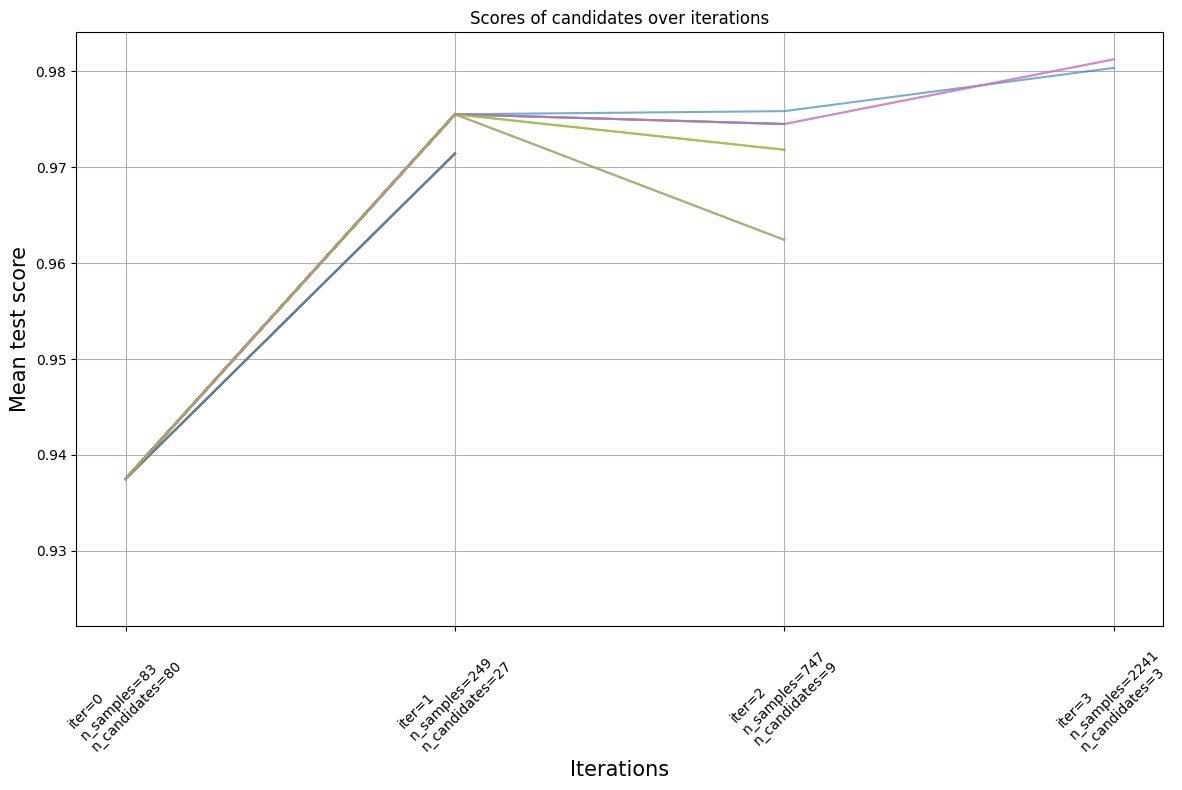

best_score: 0.9812400127836369


In [63]:
plot(grid_search)
print("best_score:", grid_search.best_score_)

In [64]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.97      0.93      0.95       123

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



С TfidfVectorizer

In [65]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
}

In [66]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

CPU times: total: 12.1 s
Wall time: 21.5 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=-1,
                    param_grid={'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy')

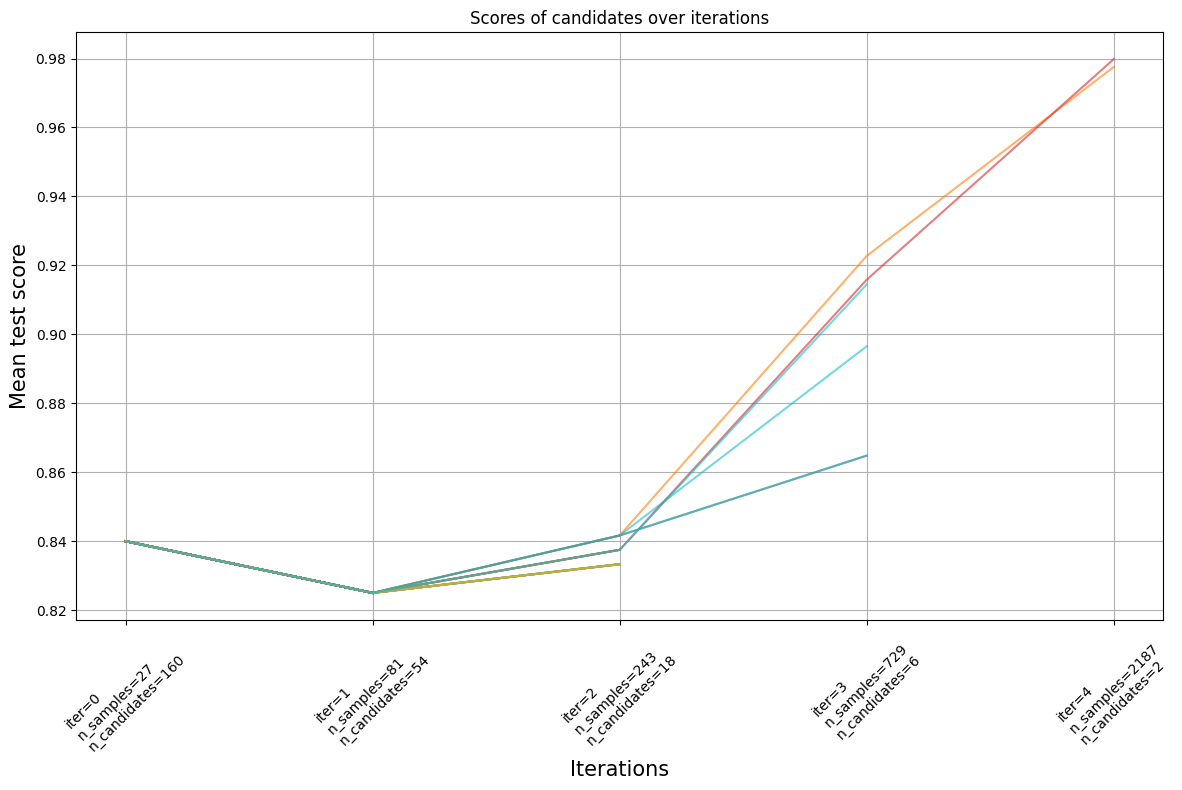

best_score: 0.9798522033044318


In [67]:
plot(grid_search)
print("best_score:", grid_search.best_score_)

In [68]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       627
           1       0.98      0.91      0.95       123

    accuracy                           0.98       750
   macro avg       0.98      0.95      0.97       750
weighted avg       0.98      0.98      0.98       750



# Вывод

На тестовых данных accuracy лучше всего у Байесовского классификатора (и с CountVectorizer, и с TfidfVectorizer) - 0.98, потом у логистической регрессии - 0.97, потом у дерева решений - 0.94.